## Import dependencies

In [1]:
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as pl
%matplotlib inline
import emcee
import astropy
from astropy.timeseries import TimeSeries
#from PyAstronomy.pyasl import foldAt

## Check versions

In [2]:
libs = [sp, mpl, emcee, astropy]
for l in libs:
    print('Current version of %s is %s' %(getattr(l, '__name__'), getattr(l, '__version__')))

Current version of scipy is 1.1.0
Current version of matplotlib is 3.0.2
Current version of emcee is 2.2.1
Current version of astropy is 3.2.1


Current version of scipy is 1.1.0

Current version of matplotlib is 3.0.2

Current version of emcee is 2.2.1

Current version of astropy is 3.2.1

## Recipe

You need 3 things to make this work. (with maybe a 4th one)

#### Prior
Degree of belief in our hipothesis.
#### Likelihood
A gaussian is always a good approximation (due to the CTL)
#### Model
!
##### Marginalization term (marginal probability, normalization term)
This one is only necessary if you want to get the real probability on your model.
This would be the degree of belief in our evidence, it gets really messy to integrate.

## Our problem
Simple sinusoid.

$$A·cos(wt + \phi)$$

## Data
### points: 50
### A = 15.1515  amplitude
### w = 2.2345  angular frequency
### $\phi$ = 0.3926  phase
### j = 1.8181  # 12% of A

In [3]:
sp.random.seed(420)
n = 60
p_, a_, ph_, j_ = 2.8181, 15.1515, 0.3926, 1.8181

x = 150 * sp.sort(sp.random.rand(n))

In [4]:
y_ = a_ * sp.cos((2. * sp.pi / p_) * x + ph_)
yerr = 0.5 * a_ * sp.random.rand(n)  # up to 50% of the signal, instrumental

j = 1.8181 * sp.random.randn(n)  # a jitter, caused by the physical phenomenom we are observing

In [5]:
y = y_ + yerr * sp.random.randn(n) + j

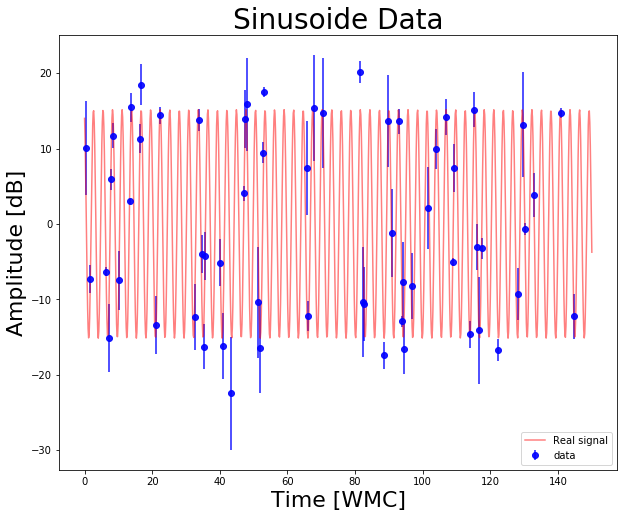

In [6]:
fig = pl.figure(figsize=(10, 8))
ax = pl.gca()
dib = ax.errorbar(x, y, yerr=yerr, fmt='bo', alpha=0.9, label='data')
ax.set_title('Sinusoide Data', fontsize=28)
ax.set_xlabel('Time [WMC]', fontsize=22)
ax.set_ylabel('Amplitude [dB]', fontsize=22)

x1 = sp.linspace(0, 150, 1000)
y1 = a_ * sp.cos((2. * sp.pi / p_) * x1 + ph_)
pl.plot(x1, y1, 'r-', label = 'Real signal', alpha=0.5)
ax.legend(loc=4)

In [7]:
def fold(x, y, yerr=None, per=None):
    if per == None:
        per = 2. * sp.pi
    x_f = x % per
    order = sp.argsort(x_f)
    if yerr is None:
        return x_f[order], y[order]
    else:
        return x_f[order], y[order], yerr[order]
    pass

In [8]:
xf, yf, yerrf = fold(x, y, per=p_, yerr=yerr)

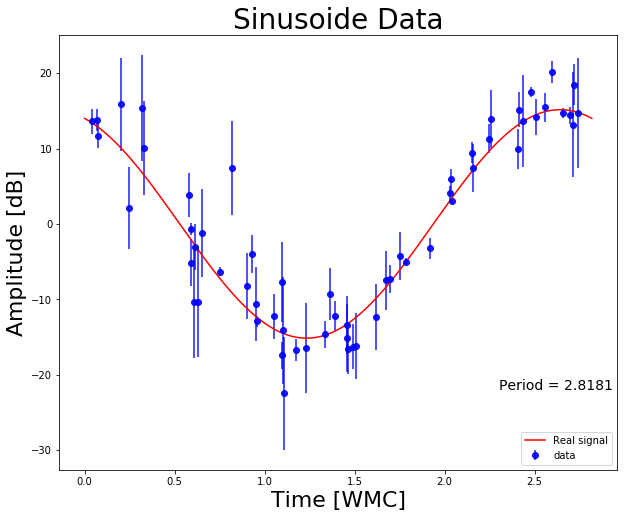

In [9]:
fig = pl.figure(figsize=(10, 8))
ax = pl.gca()
dib = ax.errorbar(xf, yf, yerr=yerrf, fmt='bo', alpha=0.9, label='data')
ax.set_title('Sinusoide Data', fontsize=28)
ax.set_xlabel('Time [WMC]', fontsize=22)
ax.set_ylabel('Amplitude [dB]', fontsize=22)

x1 = sp.linspace(0, 150, 1000)
y1 = a_ * sp.cos((2. * sp.pi / p_) * x1 + ph_)

x1f = sp.linspace(0, p_, 1000)
y1f = a_ * sp.cos((2. * sp.pi / p_) * x1f + ph_)

pl.plot(x1f, y1f, 'r-', label = 'Real signal')
pl.text(2.3, -22, 'Period = '+str(p_)[:6], fontsize=14)
ax.legend(loc=4)

# Model, Prior and Likelihood

## Model:
Simple sinusoid... could be written both with w or P, I think it's more illustrative to show with P.

In [10]:
def my_first_model(params, x):
    per, amp, pha = params
    return amp * sp.cos((2 * sp.pi / per) * x + pha)

## Prior:
Period must be $P\le 3t_{max}$

Amplitude must be $A\le 3y_{max}$

Phase always goes from 0 to $2\pi$

Jitter we will say that goes up to $3y_{max}$

Remember that priors multiply each other. In log space they add.

### Setup limits of search space

In [11]:
lims_per = [0.01, max(x)]
lims_amp = [0.01, max(y)]  
lims_pha = [0, sp.pi]
lims_jit = [0.01, sp.sqrt(max(y))]  # == lims_amp

lims = sp.array([lims_per, lims_amp, lims_pha, lims_jit])

In [12]:
sp.std(y)

12.194079202571455

In [13]:
def logprior(theta, *args):
    per, amp, pha, jit = theta  # name them for ease of use if u want
    lp = 0  # the total prior
    for i in range(len(theta)):  # goes through all params
        if lims[i, 0] <= theta[i] <= lims[i, 1]:
            lp += 0.0
        else:
            return -sp.inf
    return lp

## Likelihood:
Simple gaussian.
Remember that errors add as in quadrature.

In [14]:
def loglikelihood(theta, *args):
    per, amp, pha, jit = theta
    x, y, yerr = args
    model = my_first_model(theta[:3], x)
    inv_sigma2 = 1.0 / (yerr**2 + jit**2)
    residuals = y - model
    
    return - 0.5 * (sp.sum(residuals**2*inv_sigma2 - sp.log(inv_sigma2)))

## Combine both in a posterior function

In [15]:
def logposterior(theta, *args):
    lp = logprior(theta)
    ll = loglikelihood(theta, *args)
    return lp + ll

In [16]:
def initial_position(ndim, nwalkers, lims):
    pos0 = sp.zeros((nwalkers, ndim))
    for i in range(ndim):
        pos0[:, i] = sp.linspace(lims[i,0], lims[i,1], nwalkers)  # walkers evenly distributed in space
    return pos0

In [17]:
# multiprocessing
import multiprocessing as mp
my_cpu = mp.cpu_count()

ndim = 4  # THINGS TO FIT
nsteps = 5000 # number of iterations 2000
nwalkers = 500  # number of samplers 100

burnin = nsteps // 2


p0 = initial_position(ndim, nwalkers, lims)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(x, y, yerr), threads=my_cpu)

In [18]:
#sampler.run_mcmc(p0, nsteps)
p, lnprob, rstate = sampler.run_mcmc(p0, burnin)

sampler.reset()

p, lnprob, rstate = sampler.run_mcmc(p, nsteps, lnprob0=lnprob, rstate0=rstate)

In [19]:
samples = sampler.chain.reshape((-1, ndim))
samples = sampler.flatchain
posteriors = sampler.flatlnprobability

In [20]:
per, amp, pha, jit = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*sp.percentile(samples, [16, 50, 84],
                                                axis=0)))

## When running short chains using the maximum is more representative in big spaces**

In [21]:
print('parameters found')
print('per = ', per)
print('amp = ', amp)
print('pha = ', pha)
print('jit = ', jit)
print('rial parameters')
print('per = ', p_)
print('amp = ', a_)
print('pha = ', ph_)
print('jit = ', j_)
#2.81, 8.68, 3.38, 8.6
print('max')
per, amp, pha, jit = samples[sp.where(posteriors==max(posteriors))][0]
print(per, amp, pha, jit)

parameters found
per =  (29.825689720715776, 0.5130941447414834, 0.5398483399236333)
amp =  (7.07213808767535, 1.2571674540969777, 1.3010633894297605)
pha =  (2.5154673823729405, 0.29150462530589527, 0.44958237967688763)
jit =  (4.463827533804248, 0.01926479898209532, 0.049130643063143964)
rial parameters
per =  2.8181
amp =  15.1515
pha =  0.3926
jit =  1.8181
max
2.819211085004157 15.884012742523025 0.43288778665123906 1.2613621310827394


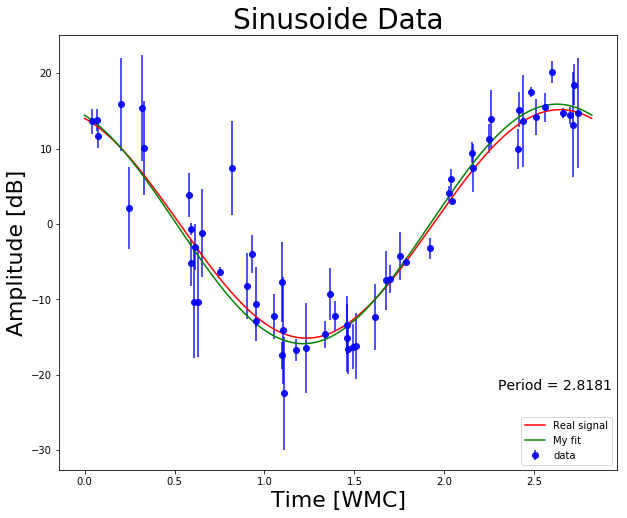

In [22]:
pl.close('all')
fig = pl.figure(figsize=(10, 8))
ax = pl.gca()
dib = ax.errorbar(xf, yf, yerr=yerrf, fmt='bo', alpha=0.9, label='data')
ax.set_title('Sinusoide Data', fontsize=28)
ax.set_xlabel('Time [WMC]', fontsize=22)
ax.set_ylabel('Amplitude [dB]', fontsize=22)

x1f = sp.linspace(0, p_, 1000)
y1f = a_ * sp.cos((2. * sp.pi / p_) * x1f + ph_)

pl.plot(x1f, y1f, 'r-', label = 'Real signal')

paramsf = sp.array([per, amp, pha])
x2f = sp.linspace(0, per, 1000)
y2f = my_first_model(paramsf, x2f)
pl.plot(x2f, y2f, 'g-', label='My fit')

pl.text(2.3, -22, 'Period = '+str(p_)[:6], fontsize=14)



ax.legend(loc=4)

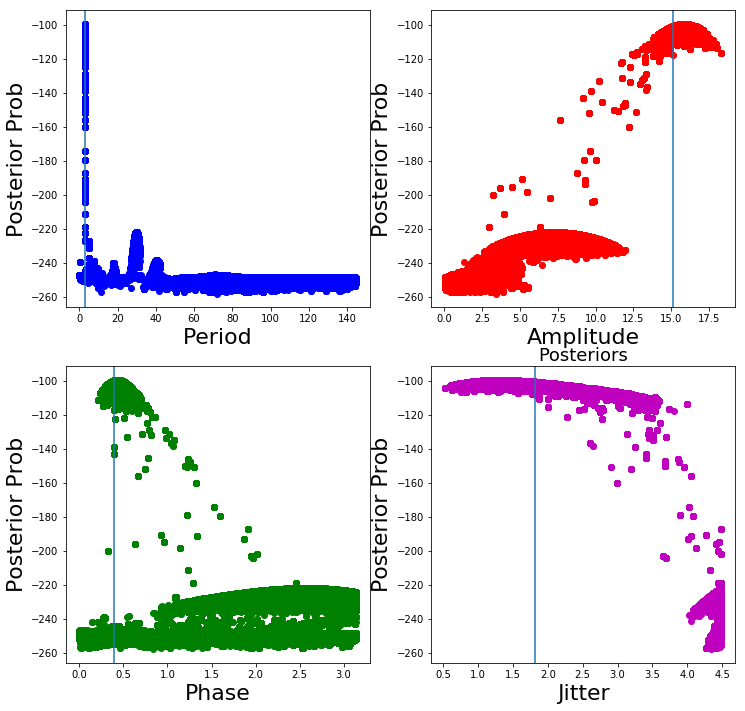

In [23]:
fig, ax = pl.subplots(2,2, figsize=(12,12))
pl.title('Posteriors', fontsize=18)
ax[0, 0].plot(samples[:, 0], posteriors, 'bo')
ax[0, 0].set_xlabel('Period', fontsize=22)
ax[0, 0].set_ylabel('Posterior Prob', fontsize=22)
l1 = ax[0, 0].axvline(p_)

ax[0, 1].plot(samples[:, 1], posteriors, 'ro')
ax[0, 1].set_xlabel('Amplitude', fontsize=22)
ax[0, 1].set_ylabel('Posterior Prob', fontsize=22)
l2 = ax[0, 1].axvline(a_)

ax[1, 0].plot(samples[:, 2], posteriors, 'go')
ax[1, 0].set_xlabel('Phase', fontsize=22)
ax[1, 0].set_ylabel('Posterior Prob', fontsize=22)
l3 = ax[1, 0].axvline(ph_)

ax[1, 1].plot(samples[:, 3], posteriors, 'mo')
ax[1, 1].set_xlabel('Jitter', fontsize=22)
ax[1, 1].set_ylabel('Posterior Prob', fontsize=22)
l4 = ax[1, 1].axvline(j_)

# Tips and tricks

## Tip #1, unfolding the circular parameters
Say we have circular parameters, $Acos_{\phi}$, with real values of $5$ and $6$:
you can unfold them using $$C = \sqrt{A}cos_{\phi} ; \\ S = \sqrt{A}sin_{\phi}$$
getting $$A = C^2 + S^2     ;  \\  \phi = arccos(\frac{C}{\sqrt{A}})$$

With this CV (nonlinear) the Jacobian in the prior and likelihood is 1!

### BONUS: log the thin ones in R+
P -> $log(P)$

In [24]:
def my_first_model1(params, x):
    per, S, C = params
    p1 = sp.exp(per)
    amp = S ** 2 + C ** 2
    pha = sp.arccos(C / (amp ** 0.5))
    return amp * sp.cos((2 * sp.pi / p1) * x + pha)

## Why not real functions in the priors?

In [25]:
ly = sp.sqrt(max(y))

lims_per = [sp.log(0.0001), sp.log(max(x))]
lims_S = [-ly, ly]
lims_C = [-ly, ly]
lims_jit = [0.0001, ly]  # == lims_amp

lims = sp.array([lims_per, lims_S, lims_C, lims_jit])


def uniform(x, lims, args=None):
    if lims[0] <= x <= lims[1]:
        return 0.
    else:
        return -sp.inf
    
def normal(x, lims, args=[2, 1]):
    if lims[0] <= x <= lims[1]:
        mean, var = args[0], 2*args[1]
        return ( - (x - mean) ** 2 / var)
    else:
        return -sp.inf
    
priors = sp.array([uniform, uniform, uniform, normal])

In [26]:
def logprior1(theta, *args):
    per, S, C, jit = theta  # name them for ease of use if u want
    lp = 0  # the total prior
    for i in range(len(theta)):  # goes through all params
        lp += priors[i](theta[i], lims[i])
    
    A = S**2 + C**2
    lp += uniform(A, lims_amp)    
    
    return lp

def loglikelihood1(theta, *args):
    per, S, C, jit = theta
    x, y, yerr = args
    model = my_first_model1(theta[:3], x)
    inv_sigma2 = 1.0 / (yerr**2 + jit**2)
    residuals = y - model
    
    return - 0.5 * (sp.sum(residuals**2*inv_sigma2 - sp.log(inv_sigma2)))

def logposterior1(theta, *args):
    lp = logprior1(theta)
    ll = loglikelihood1(theta, *args)
    return lp + ll

### BONUS TIP: scramble so they don't get stucked on the start

In [27]:
ndim = 4  # THINGS TO FIT

burnin = nsteps // 2

p0 = initial_position(ndim, nwalkers, lims)

p0[:, 2] *= sp.random.uniform(0.80, 0.99, nwalkers)


sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior1, args=(x, y, yerr), threads=my_cpu)

## Tip #2 use the space!!
Loading bars, saving data and reset (less RAM), 

In [28]:
from tqdm import tqdm
loading_bar_1 = tqdm(total=burnin)
loading_bar_2 = tqdm(total=nsteps)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [29]:
#sampler.run_mcmc(p0, nsteps)

for p, lnprob, rstate in sampler.sample(p0, iterations=burnin):
    loading_bar_1.update(1)
    pass

# save burnin?
sampler.reset()
loading_bar_1.close()


for p, lnprob, rstate in sampler.sample(p, lnprob0=lnprob,
                                        rstate0=rstate,
                                        iterations=nsteps):
    loading_bar_2.update(2)
    pass

loading_bar_2.close()

/home/reddtea/.local/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/reddtea/.local/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
100%|██████████| 2500/2500 [00:29<00:00, 86.16it/s]
10000it [01:28, 112.57it/s]                         


In [30]:
samples = sampler.chain.reshape((-1, ndim))
samples = sampler.flatchain
posteriors = sampler.flatlnprobability

def henshin(thetas):
    P = sp.exp(thetas[:, 0])
    A = thetas[:,1] ** 2 + thetas[:, 2] ** 2
    Phase = sp.arccos(thetas[:, 2] / (A ** 0.5))
    
    thetas_h = sp.zeros(thetas.shape)
    thetas_h[:, 0] = P
    thetas_h[:, 1] = A
    thetas_h[:, 2] = Phase
    thetas_h[:, 3] = thetas[:, 3]
    return thetas_h

samples_h = henshin(samples)

per, amp, pha, jit = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*sp.percentile(samples_h, [16, 50, 84],
                                                axis=0)))

In [31]:
print('parameters found')
print('per = ', per)
print('amp = ', amp)
print('pha = ', pha)
print('jit = ', jit)
print('rial parameters')
print('per = ', p_)
print('amp = ', a_)
print('pha = ', ph_)
print('jit = ', j_)

parameters found
per =  (2.8192939211118366, 0.001366846460728599, 0.001061324720912804)
amp =  (15.700138425190003, 0.544853074958672, 1.0667895799356302)
pha =  (0.44520354374048854, 0.1110633403936725, 0.059974072319366856)
jit =  (1.6239851723549827, 0.8612654122322165, 0.37773265175480986)
rial parameters
per =  2.8181
amp =  15.1515
pha =  0.3926
jit =  1.8181


In [32]:
per1, amp1, pha1, jit1 = samples[sp.where(posteriors==max(posteriors))][0]
perh, amph, phah, jith = samples_h[sp.where(posteriors==max(posteriors))][0]

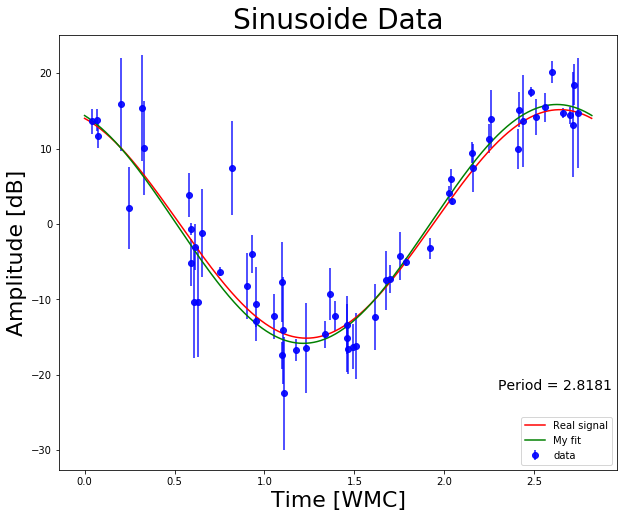

In [33]:
pl.close('all')
fig = pl.figure(figsize=(10, 8))
ax = pl.gca()
dib = ax.errorbar(xf, yf, yerr=yerrf, fmt='bo', alpha=0.9, label='data')
ax.set_title('Sinusoide Data', fontsize=28)
ax.set_xlabel('Time [WMC]', fontsize=22)
ax.set_ylabel('Amplitude [dB]', fontsize=22)

x1f = sp.linspace(0, p_, 1000)
y1f = a_ * sp.cos((2. * sp.pi / p_) * x1f + ph_)

pl.plot(x1f, y1f, 'r-', label = 'Real signal')

paramsf = sp.array([per1, amp1, pha1])
x2f = sp.linspace(0, perh, 1000)
y2f = my_first_model1(paramsf, x2f)
pl.plot(x2f, y2f, 'g-', label='My fit')

pl.text(2.3, -22, 'Period = '+str(p_)[:6], fontsize=14)



ax.legend(loc=4)

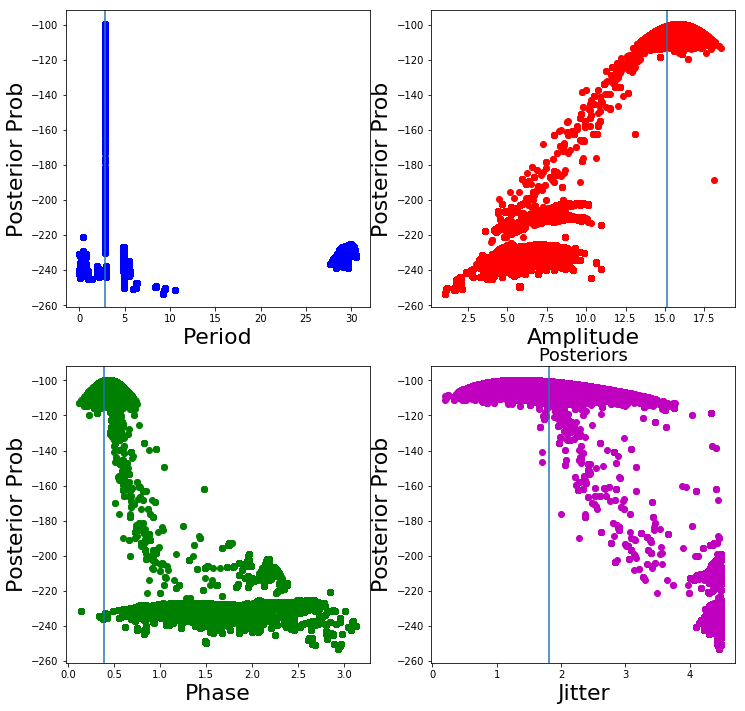

In [34]:
fig, ax = pl.subplots(2,2, figsize=(12,12))
pl.title('Posteriors', fontsize=18)
ax[0, 0].plot(samples_h[:, 0], posteriors, 'bo')
ax[0, 0].set_xlabel('Period', fontsize=22)
ax[0, 0].set_ylabel('Posterior Prob', fontsize=22)
l1 = ax[0, 0].axvline(p_)

ax[0, 1].plot(samples_h[:, 1], posteriors, 'ro')
ax[0, 1].set_xlabel('Amplitude', fontsize=22)
ax[0, 1].set_ylabel('Posterior Prob', fontsize=22)
l2 = ax[0, 1].axvline(a_)

ax[1, 0].plot(samples_h[:, 2], posteriors, 'go')
ax[1, 0].set_xlabel('Phase', fontsize=22)
ax[1, 0].set_ylabel('Posterior Prob', fontsize=22)
l3 = ax[1, 0].axvline(ph_)

ax[1, 1].plot(samples_h[:, 3], posteriors, 'mo')
ax[1, 1].set_xlabel('Jitter', fontsize=22)
ax[1, 1].set_ylabel('Posterior Prob', fontsize=22)
l4 = ax[1, 1].axvline(j_)

## Tip #3 ! Use python

## Use dictionaries to hold metadata of the parameters!

In [35]:
_period = {'name':'Period',
           'units':'Julian Days',
           'prior':uniform,
           'lims':lims_per,
           'value':-sp.inf,
           'args':None,
           'type':'Sinusoid'}
_amplitude = {'name':'Amplitude',
              'units':'$\frac{m}{s}$',
              'prior':uniform,
              'lims':lims_amp,
              'value':-sp.inf,
              'args':None,
              'type':'Sinusoid'}
_phase = {'name':'Phase',
          'units':'rad',
          'prior':'fixed',
          'lims':lims_pha,
          'value':ph_,
          'args':None,
          'type':'Sinusoidal'}
_jitter = {'name':'Jitter',
           'units':'$\frac{m}{s}',
           'prior':normal,
           'lims':lims_jit,
           'value':-sp.inf,
           'args':None,
           'type':'Noise'}

metadata = sp.array([_period, _amplitude, _phase, _jitter])
C_ = sp.array([0, 1, 3])
A_ = sp.array([2])
ndim = len(C_)

In [36]:
def logprior_d(theta, *args):
    lp = 0  # the total prior
    for i in range(len(theta)):  # goes through all params
        param = metadata[C_[i]]
        lp += param['prior'](theta[i], param['lims'])
    return lp

def loglikelihood_d(theta, *args):
    x, y, yerr = args
    
    for a in A_:  # inserts the fixed params
        theta = sp.insert(theta, a, metadata[a]['value'])

    model = my_first_model_d(theta[:3], x)
    inv_sigma2 = 1.0 / (yerr**2 + theta[3]**2)
    residuals = y - model
    
    return - 0.5 * (sp.sum(residuals**2*inv_sigma2 - sp.log(inv_sigma2)))

def logposterior_d(theta, *args):
    lp = logprior_d(theta)
    ll = loglikelihood_d(theta, *args)
    return lp + ll

def my_first_model_d(params, x):
    per, amp, pha = params
    p1 = sp.exp(per)
    
    return amp * sp.cos((2 * sp.pi / p1) * x + pha)

def initial_position_d(metadata, C_, nwalkers):
    ndim = len(C_)
    pos0 = sp.zeros((nwalkers, ndim))
    for i in range(ndim):  # for non fixed parameters
        lims = metadata[C_[i]]['lims']
        pos0[:, i] = sp.linspace(lims[0], lims[1], nwalkers)  # walkers evenly distributed in space
    return pos0

In [37]:
p0 = initial_position_d(metadata, C_, nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior_d, args=(x, y, yerr), threads=my_cpu)

In [38]:
loading_bar_1 = tqdm(total=burnin)
loading_bar_2 = tqdm(total=nsteps)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [39]:
for p, lnprob, rstate in sampler.sample(p0, iterations=burnin):
    loading_bar_1.update(1)
    pass

sampler.reset()
loading_bar_1.close()


for p, lnprob, rstate in sampler.sample(p, lnprob0=lnprob,
                                        rstate0=rstate,
                                        iterations=nsteps):
    loading_bar_2.update(2)
    pass

loading_bar_2.close()

100%|██████████| 2500/2500 [00:34<00:00, 71.52it/s]
10000it [01:48, 91.83it/s]                          


In [40]:
samples = sampler.chain.reshape((-1, ndim))
samples = sampler.flatchain
samples[:, 0] = sp.exp(samples[:, 0])
posteriors = sampler.flatlnprobability
per, amp, jit = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*sp.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [41]:
print('parameters found')
print('per = ', per)
print('A = ', amp)
print('jit = ', jit)
print('rial parameters')
print('per = ', p_)
print('amp = ', a_)
print('pha = ', ph_)
print('jit = ', j_)

parameters found
per =  (2.8183203285929053, 0.0007290663119055019, 2.798112966815019)
A =  (15.5271383559183, 0.6605102191351513, 9.988004506202579)
jit =  (1.7405227986024414, 2.676742223270475, 0.4894702532692674)
rial parameters
per =  2.8181
amp =  15.1515
pha =  0.3926
jit =  1.8181


In [42]:
per2, amp2, jit2 = samples[sp.where(posteriors==max(posteriors))][0]
per2

2.818647291030341

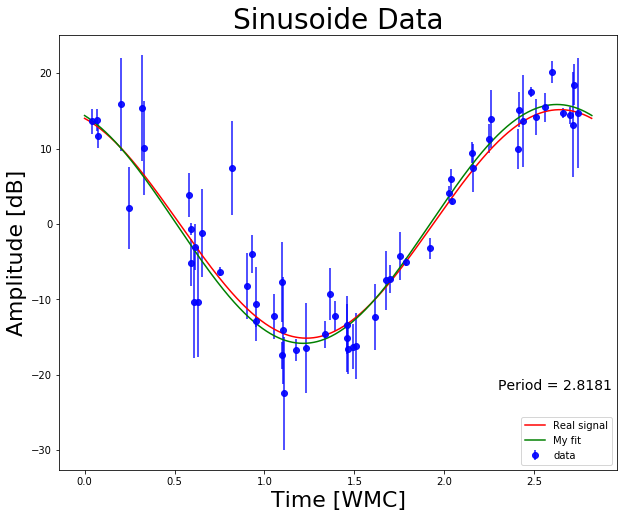

In [43]:
pl.close('all')
fig = pl.figure(figsize=(10, 8))
ax = pl.gca()
dib = ax.errorbar(xf, yf, yerr=yerrf, fmt='bo', alpha=0.9, label='data')
ax.set_title('Sinusoide Data', fontsize=28)
ax.set_xlabel('Time [WMC]', fontsize=22)
ax.set_ylabel('Amplitude [dB]', fontsize=22)

x1f = sp.linspace(0, p_, 1000)
y1f = a_ * sp.cos((2. * sp.pi / p_) * x1f + ph_)

pl.plot(x1f, y1f, 'r-', label = 'Real signal')

paramsf = sp.array([per1, amp1, pha1])
x2f = sp.linspace(0, perh, 1000)
y2f = my_first_model1(paramsf, x2f)
pl.plot(x2f, y2f, 'g-', label='My fit')

pl.text(2.3, -22, 'Period = '+str(p_)[:6], fontsize=14)



ax.legend(loc=4)

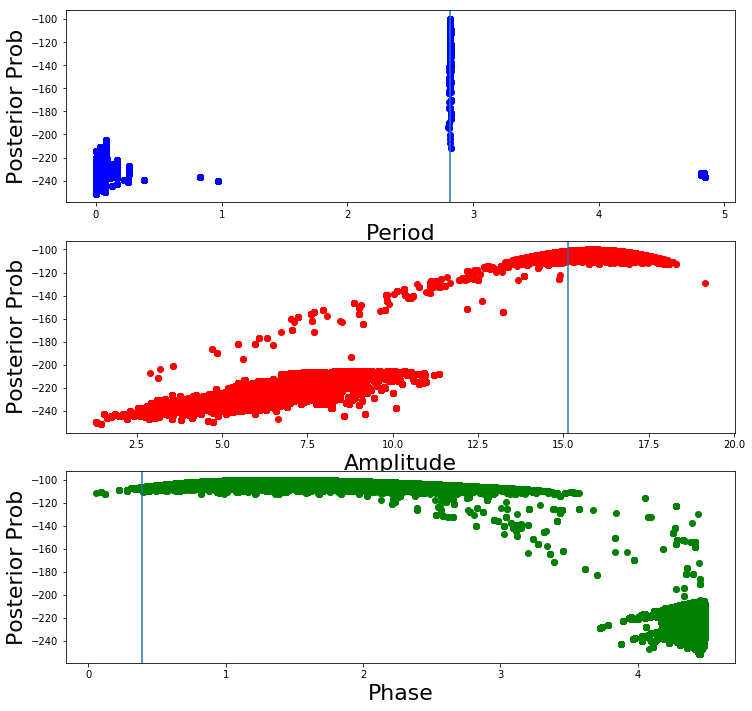

In [44]:
pl.close('all')
fig, ax = pl.subplots(3,1, figsize=(12,12))
colors = ['bo', 'ro', 'go']
true_p = [p_, a_, ph_, j_]
for col in range(3):
    ax[col].plot(samples[:, col], posteriors, colors[col])
    ax[col].set_xlabel(metadata[col]['name'], fontsize=22)
    ax[col].set_ylabel('Posterior Prob', fontsize=22)
    ax[col].axvline(true_p[col])

In [45]:
class spec:
    '''
    This object holds metadata on each parameter
    '''
    def __init__(self, name, units, prior, lims, val, type, args=[]):
        self.name = name
        self.units = units
        self.prior = prior
        self.lims = lims
        self.val = -sp.inf
        self.args = args
        self.type = type
    def __prior(self, x, *args):
        return self.__prior(x, args)

In [46]:
class spec_list:
    '''
    This class allows to order the specs in a list, gives some useful methods(?)
    and recovers some traditional ones.
    '''
    def __init__(self):
        self.list_ = sp.array([])
        self.ndim_ = 0
        self.gral_priors = sp.array([])

        self.C = []  # coordinator
        self.A = []  # anticoordinator
        
    def len(self):
        '''
        returns len of list
        '''
        return len(self.list_)
    
    def _update_list_(self):
        '''
        updates ndim and coordinator and anticoordinator
        '''
        ndim = self.len()
        priors = self.list('prior')
        for i in range(self.len()):
            if priors[i] == 'fixed':
                ndim -= 1
                self.A.append(i)
            else:
                self.C.append(i)
        self.ndim_ = ndim
        pass

    def change_val(self, commands):
        '''
        To change values only knowing the name!
        '''
        object_id, action = commands[:2]
        whato = commands[2:]
        if len(whato) == 1:  # dictionary quickfix
            whato = commands[2]  # dictionary quickfix
        for theta in self.list_:
            if theta.name == object_id:
                setattr(theta, action, whato)
                return True
        return False

    def apply_changes_list(self, changes_list):
        used = []
        for j in changes_list.keys():
            if self.change_val(changes_list[j]):
                print('Following condition has been applied: ', changes_list[j])
                used.append(j)
        for j in used[::-1]:
            del changes_list[j]
        pass

    def list(self, *call):
        '''
        returns the called attributes for each item in the list as an array
        '''
        if len(call) == 1:
            return sp.array([getattr(self.list_[i], call[0]) for i in range(len(self.list_))])
        else:
            return sp.array([sp.array([getattr(self.list_[i], c) for i in range(len(self.list_))]) for c in call])

In [47]:
t_ = spec_list()

In [48]:
names = ["Period", "Amplitude", "Phase", "Jitter"]
units = [" [Days]", " $[\\frac{m}{s}]$", " $[rad]$", " $[\\frac{m}{s}]$"]
priors = ['fixed', uniform, uniform, normal]
values = [sp.log(p_), -sp.inf, -sp.inf, -sp.inf]


for i in range(4):
    t = spec(names[i], units[i], priors[i], lims[i], -sp.inf, 'keplerian', args=[0.0001, conditions[0]])

NameError: name 'conditions' is not defined